# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
!pip install scikit-optimize

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV
from skopt.space import Integer
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [3]:
# Memuat dataset
df = pd.read_csv('/content/Data_hasil_clustering.csv')
df.head()

,Unit_Price,Quantity,Discount,Total_Price,Customer_Type,Cluster
0,1.58,53.0,0.1,75.37,B2B,2
1,3.12,5.0,0.0,15.60,B2C,1
2,2.16,91.0,0.1,176.90,B2B,2
3,3.67,12.0,0.0,44.04,B2C,1
4,1.54,5.0,0.0,7.70,B2C,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18366 entries, 0 to 18365
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unit_Price     18366 non-null  float64
 1   Quantity       18366 non-null  float64
 2   Discount       18366 non-null  float64
 3   Total_Price    18366 non-null  float64
 4   Customer_Type  18366 non-null  object 
 5   Cluster        18366 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 861.0+ KB


# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [5]:
# One-Hot Encoding untuk Customer_Type
ohe = OneHotEncoder(drop=None, sparse_output=False)
ohe_encoded = ohe.fit_transform(df[["Customer_Type"]])
ohe_df = pd.DataFrame(ohe_encoded, columns=ohe.get_feature_names_out(["Customer_Type"]))
df = df.drop(columns=["Customer_Type"]).join(ohe_df)

In [6]:
# Memisahkan fitur dan target
X = df.drop(columns=["Cluster"])
y = df["Cluster"]

In [7]:
X.head()

,Unit_Price,Quantity,Discount,Total_Price,Customer_Type_B2B,Customer_Type_B2C
0,1.58,53.0,0.1,75.37,1.0,0.0
1,3.12,5.0,0.0,15.60,0.0,1.0
2,2.16,91.0,0.1,176.90,1.0,0.0
3,3.67,12.0,0.0,44.04,0.0,1.0
4,1.54,5.0,0.0,7.70,0.0,1.0


In [8]:
y.head()

,Cluster
0,2
1,1
2,2
3,1
4,1


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
# Tampilkan bentuk set pelatihan dan set uji untuk memastikan split
print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test set shape: X_test={X_test.shape}, y_test={y_test.shape}")

Training set shape: X_train=(14692, 6), y_train=(14692,)
Test set shape: X_test=(3674, 6), y_test=(3674,)


# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [11]:
# Inisialisasi Model
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Naïve Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

Saya menggunakan 5 algoritma klasifikasi **(Random Forest, Decision Tree, Naïve Bayes, K-Nearest Neighbors, dan Logistic Regression)** untuk memastikan pemilihan model yang paling optimal. Setiap algoritma memiliki karakteristik berbeda, sehingga dengan membandingkan beberapa model, kita dapat menghindari bias terhadap satu metode tertentu. Selain itu, penggunaan beberapa algoritma memungkinkan kita untuk mengakomodasi berbagai tipe data dan menyeimbangkan antara kompleksitas serta performa model.

Dalam membangun model klasifikasi, beberapa algoritma yang saya gunakan untuk menganalisis dan memprediksi kelas dari data adalah sebagai berikut.

- Random Forest

Algoritma berbasis ensemble yang terdiri dari banyak Decision Tree. Menggunakan teknik bagging, di mana setiap pohon dilatih dengan subset data yang berbeda. Memiliki keunggulan dalam menangani overfitting dibanding Decision Tree tunggal.

- Decision Tree

Model berbasis pohon keputusan yang membagi data ke dalam cabang-cabang berdasarkan fitur yang paling signifikan. Mudah dipahami dan diinterpretasikan, tetapi rentan terhadap overfitting jika tidak diatur dengan baik.

- Naïve Bayes

Algoritma berbasis Teorema Bayes, yang mengasumsikan bahwa fitur dalam dataset saling independen. Cocok untuk data kategorikal dan teks, seperti klasifikasi email spam atau analisis sentimen.

- K-Nearest Neighbors (KNN)

Metode berbasis jarak yang mengklasifikasikan data berdasarkan mayoritas kelas dari k tetangga terdekat. Sensitif terhadap skala fitur, sehingga membutuhkan normalisasi sebelum digunakan.

- Logistic Regression

Model statistik yang digunakan untuk klasifikasi biner dengan menghitung probabilitas menggunakan fungsi sigmoid. Efektif untuk data linier, tetapi kurang baik jika hubungan antar fitur kompleks.

Setelah inisialisasi model, setiap algoritma akan dilatih menggunakan data latih, kemudian dievaluasi untuk menentukan model terbaik.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.

In [12]:
# Fungsi Evaluasi Model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)  # Melatih model
    y_test_pred = model.predict(X_test)

    # Classification report
    class_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Mengonversi hasil classification report ke DataFrame
    class_report_df = pd.DataFrame(class_report).T
    class_report_df.insert(0, "Model", model_name)  # Tambahkan kolom Model
    print(f"\n=== Classification Report untuk {model_name} ===\n")
    print(classification_report(y_test, y_test_pred))

    return class_report_df

# Evaluasi Model untuk Semua Model
results = []
for name, model in models.items():
    results.append(evaluate_model(model, X_train, X_test, y_train, y_test, name))

# Gabungkan hasil evaluasi dari semua model
evaluation_df = pd.concat(results)


=== Classification Report untuk Random Forest ===

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       691
           1       1.00      1.00      1.00      2404
           2       1.00      0.99      0.99       579

    accuracy                           1.00      3674
   macro avg       1.00      1.00      1.00      3674
weighted avg       1.00      1.00      1.00      3674


=== Classification Report untuk Decision Tree ===

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       691
           1       1.00      1.00      1.00      2404
           2       0.99      0.99      0.99       579

    accuracy                           1.00      3674
   macro avg       0.99      0.99      0.99      3674
weighted avg       1.00      1.00      1.00      3674


=== Classification Report untuk Naïve Bayes ===

              precision    recall  f1-score   support

           0       0.99      

In [13]:
# Fungsi Evaluasi Model Klasifikasi
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)  # Melatih model
    y_test_pred = model.predict(X_test)

    # Menghitung metrik evaluasi model klasifikasi
    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred, average='weighted'),
        "Recall": recall_score(y_test, y_test_pred, average='weighted'),
        "F1-score": f1_score(y_test, y_test_pred, average='weighted'),
    }

    return metrics

# Evaluasi Model Klasifikasi Keseluruhan 5 Algoritma
results = []
for name, model in models.items():
    results.append(evaluate_model(model, X_train, X_test, y_train, y_test, name))

evaluation_df = pd.DataFrame(results)

# Menampilkan hasil evaluasi
pd.options.display.float_format = '{:.4f}'.format
display(evaluation_df)

,Model,Accuracy,Precision,Recall,F1-score
0,Random Forest,0.9978,0.9978,0.9978,0.9978
1,Decision Tree,0.9973,0.9973,0.9973,0.9973
2,Naïve Bayes,0.9954,0.9954,0.9954,0.9954
3,K-Nearest Neighbors,0.9654,0.9649,0.9654,0.9651
4,Logistic Regression,0.9829,0.9828,0.9829,0.9828


Saya sudah melakukan evaluasi model klasifikasi dengan 5 jenis algoritma, kemudian untuk mengkerucutkannya lagi saya akan memilih 2 model klasifikasi yang terbaik.


Model Terbaik: ['Random Forest', 'Decision Tree']

=== Evaluasi Model Terbaik (Keseluruhan) ===


,Model,Accuracy,Precision,Recall,F1-score
0,Random Forest,0.9978,0.9978,0.9978,0.9978
1,Decision Tree,0.9973,0.9973,0.9973,0.9973



=== Classification Report untuk Random Forest ===
       Class  precision  recall  f1-score   support
           0     0.9900  0.9986    0.9942  691.0000
           1     1.0000  1.0000    1.0000 2404.0000
           2     0.9983  0.9879    0.9931  579.0000
    accuracy     0.9978  0.9978    0.9978    0.9978
   macro avg     0.9961  0.9955    0.9958 3674.0000
weighted avg     0.9978  0.9978    0.9978 3674.0000

=== Classification Report untuk Decision Tree ===
       Class  precision  recall  f1-score   support
           0     0.9899  0.9957    0.9928  691.0000
           1     1.0000  1.0000    1.0000 2404.0000
           2     0.9948  0.9879    0.9913  579.0000
    accuracy     0.9973  0.9973    0.9973    0.9973
   macro avg     0.9949  0.9945    0.9947 3674.0000
weighted avg     0.9973  0.9973    0.9973 3674.0000


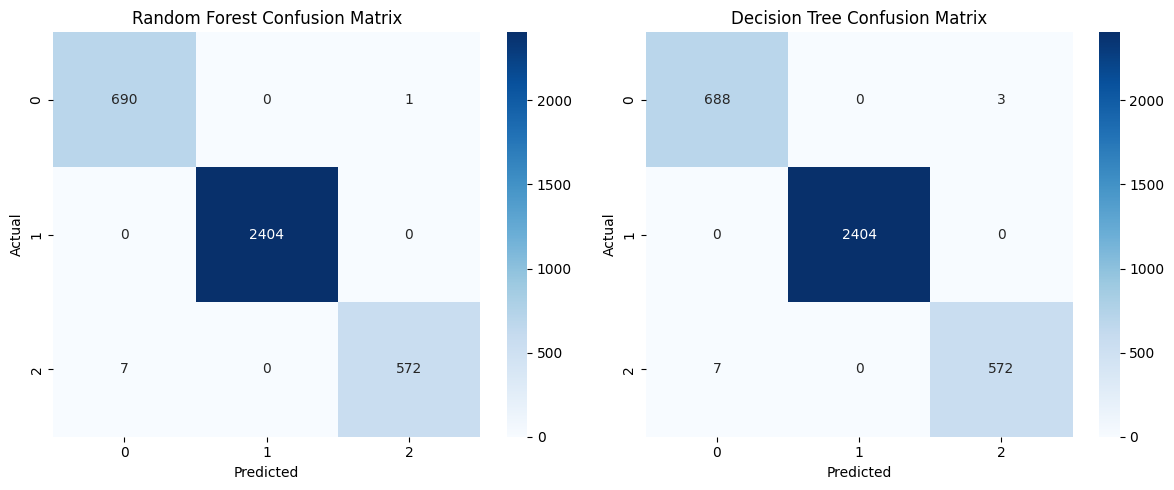

In [14]:
# Memilih 2 Model Terbaik
top_models = evaluation_df.nlargest(2, "F1-score")["Model"].tolist()
print("\nModel Terbaik:", top_models)

# Menampilkan Evaluasi Model Terbaik dalam satu tabel
best_models_eval = evaluation_df[evaluation_df["Model"].isin(top_models)]
print("\n=== Evaluasi Model Terbaik (Keseluruhan) ===")
display(best_models_eval)

# Menampilkan Evaluasi Per Kelas untuk Model Terbaik
for model_name in top_models:
    model = models[model_name]
    y_test_pred = model.predict(X_test)
    class_report = classification_report(y_test, y_test_pred, output_dict=True)
    class_df = pd.DataFrame(class_report).T
    class_df = class_df.rename_axis("Class").reset_index()
    print(f"\n=== Classification Report untuk {model_name} ===")
    print(class_df.to_string(index=False))

# Menampilkan Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, model_name in enumerate(top_models):
    model = models[model_name]
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)
    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{model_name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
plt.tight_layout()
plt.show()

Dalam membangun model klasifikasi, digunakan 5 algoritma berbeda, yaitu **Random Forest, Decision Tree, Naïve Bayes, K-Nearest Neighbors (KNN), dan Logistic Regression**. Pemilihan 5 algoritma ini bertujuan untuk membandingkan performa model dari berbagai pendekatan, baik berbasis pohon keputusan, probabilistik, maupun berbasis tetangga terdekat. Dengan membandingkan lebih banyak algoritma, kita dapat mengidentifikasi model yang paling optimal untuk dataset yang digunakan.

Berdasarkan evaluasi awal menggunakan metrik seperti akurasi, precision, recall, dan F1-score, dua model terbaik yang dipilih adalah **Random Forest dan Decision Tree**. Berdasarkan hasil evaluasi, **Random Forest** terlihat lebih unggul dibandingkan Decision Tree. Meskipun keduanya memiliki akurasi dan F1-score yang sangat tinggi, Random Forest lebih stabil dalam menghadapi variasi data dan lebih tahan terhadap overfitting karena menggunakan ensemble dari banyak pohon keputusan. Sementara itu, Decision Tree cenderung lebih sederhana dan cepat, tetapi memiliki risiko overfitting yang lebih tinggi, terutama jika tidak dilakukan pruning atau regularisasi yang baik.

Dari confusion matrix, Random Forest juga menunjukkan hasil yang sedikit lebih baik dalam hal jumlah kesalahan klasifikasi yang lebih kecil dibandingkan Decision Tree. Oleh karena itu, **jika harus memilih satu model yang lebih direkomendasikan untuk digunakan, Random Forest adalah pilihan yang lebih baik** karena memberikan keseimbangan antara akurasi tinggi dan generalisasi yang lebih baik terhadap data baru.

## **c. Tuning Model Klasifikasi (Optional)**

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

In [15]:
# Parameter tuning menggunakan Bayesian Optimization
rf_params = {
    "n_estimators": Integer(50, 150),
    "max_depth": Integer(10, 30),
    "min_samples_split": Integer(2, 10),
    "min_samples_leaf": Integer(1, 4)
}

dt_params = {
    "max_depth": Integer(10, 30),
    "min_samples_split": Integer(2, 10),
    "min_samples_leaf": Integer(1, 4)
}

# Tuning Random Forest dengan Bayesian Optimization
rf_bayes = BayesSearchCV(RandomForestClassifier(random_state=42), rf_params, n_iter=30, cv=3, scoring='f1_weighted', n_jobs=-1, random_state=42)
rf_bayes.fit(X_train, y_train)

# Tuning Decision Tree dengan Bayesian Optimization
dt_bayes = BayesSearchCV(DecisionTreeClassifier(random_state=42), dt_params, n_iter=30, cv=3, scoring='f1_weighted', n_jobs=-1, random_state=42)
dt_bayes.fit(X_train, y_train)

# Menampilkan hyperparameter terbaik
print("\n=== Hyperparameter Terbaik ===\n")
print("Best Random Forest Params:", rf_bayes.best_params_)
print("Best Decision Tree Params:", dt_bayes.best_params_)

# Model terbaik setelah tuning
best_rf = rf_bayes.best_estimator_
best_dt = dt_bayes.best_estimator_

print("\n✅ Model terbaik telah disimpan\n")

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.int64(27), np.int64(4), np.int64(4)] before, using random point [np.int64(19), np.int64(2), np.int64(8)]
  warnings.warn(



=== Hyperparameter Terbaik ===

Best Random Forest Params: OrderedDict([('max_depth', 22), ('min_samples_leaf', 3), ('min_samples_split', 5), ('n_estimators', 137)])
Best Decision Tree Params: OrderedDict([('max_depth', 23), ('min_samples_leaf', 1), ('min_samples_split', 3)])

✅ Model terbaik telah disimpan



Setelah dilakukan Bayesian Optimization menggunakan BayesSearchCV, diperoleh hyperparameter terbaik untuk Random Forest dan Decision Tree.

Untuk Random Forest, hasil tuning menunjukkan bahwa model terbaik memiliki:

- max_depth = 22 → Kedalaman pohon mencapai 22, memungkinkan model menangkap pola yang lebih kompleks tetapi tetap mempertahankan generalisasi.
- min_samples_leaf = 3 → Setiap daun minimal memiliki 3 sampel, membantu mengurangi overfitting dengan memastikan bahwa pohon tidak terlalu spesifik terhadap data pelatihan.
- min_samples_split = 5 → Node akan dipecah hanya jika memiliki minimal 5 sampel, yang membantu model menemukan keseimbangan antara detail dan generalisasi.
- n_estimators = 137 → Model menggunakan 137 pohon, memberikan kekuatan ensemble yang cukup tanpa mengorbankan efisiensi komputasi.

Sementara itu, untuk Decision Tree, hyperparameter terbaik yang ditemukan adalah:

- max_depth = 23 → Pohon memiliki kedalaman 23, memungkinkan model menangkap lebih banyak informasi dari data tanpa terlalu berlebihan.
- min_samples_leaf = 1 → Setiap daun dapat memiliki hanya 1 sampel, memberikan fleksibilitas maksimal tetapi meningkatkan risiko overfitting.
- min_samples_split = 3 → Node akan dipecah jika ada minimal 3 sampel, memberikan keseimbangan antara model yang terlalu sederhana dan terlalu kompleks.

Dengan hyperparameter ini, model telah dioptimalkan untuk meningkatkan keseimbangan antara akurasi dan generalisasi. Evaluasi lebih lanjut akan dilakukan untuk membandingkan performa sebelum dan setelah tuning guna memastikan peningkatan kualitas prediksi.

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.


=== Evaluasi Model Setelah Tuning ===

              Model  Accuracy  Precision  Recall  F1-score
Tuned Random Forest   99.8095     0.9981  0.9981    0.9981
Tuned Decision Tree   99.7278     0.9973  0.9973    0.9973

=== Evaluasi Per Kelas (Classification Report) setelah tuning ===


 Classification Report untuk Tuned Random Forest
       Class  precision  recall  f1-score   support
           0     0.9914  0.9986    0.9950  691.0000
           1     1.0000  1.0000    1.0000 2404.0000
           2     0.9983  0.9896    0.9939  579.0000
    accuracy     0.9981  0.9981    0.9981    0.9981
   macro avg     0.9965  0.9961    0.9963 3674.0000
weighted avg     0.9981  0.9981    0.9981 3674.0000



 Classification Report untuk Tuned Decision Tree
       Class  precision  recall  f1-score   support
           0     0.9899  0.9957    0.9928  691.0000
           1     1.0000  1.0000    1.0000 2404.0000
           2     0.9948  0.9879    0.9913  579.0000
    accuracy     0.9973  0.9973    0.9973

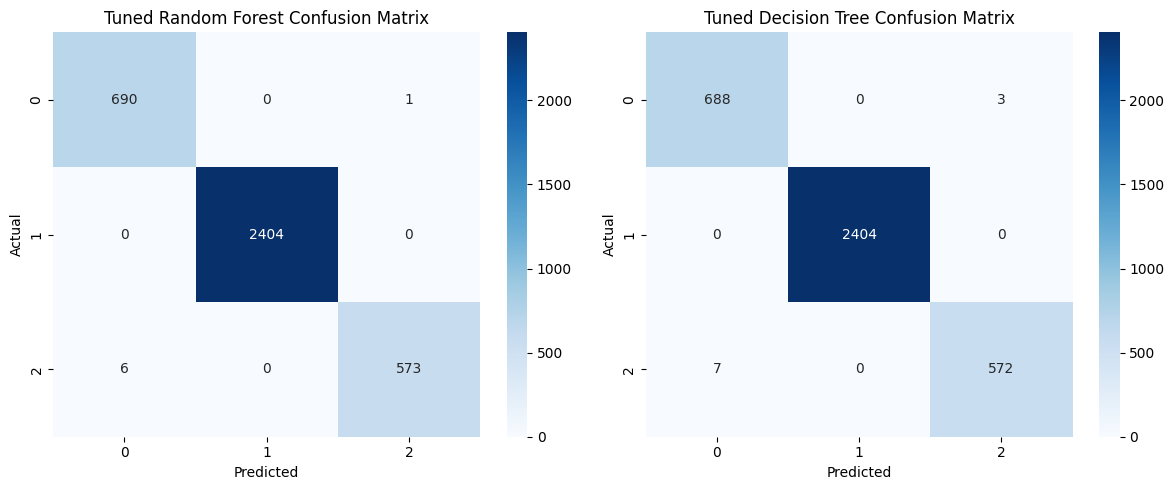

In [16]:
# Fungsi evaluasi model Klasifikasi
def evaluate_model(model, X_test, y_test, model_name):
    y_test_pred = model.predict(X_test)

    metrics = {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_test_pred) * 100,
        "Precision": precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
        "F1-score": f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    }
    return metrics

# Evaluasi model setelah tuning
tuned_results = []
tuned_results.append(evaluate_model(best_rf, X_test, y_test, "Tuned Random Forest"))
tuned_results.append(evaluate_model(best_dt, X_test, y_test, "Tuned Decision Tree"))

tuned_evaluation_df = pd.DataFrame(tuned_results)
print("\n=== Evaluasi Model Setelah Tuning ===\n")
print(tuned_evaluation_df.to_string(index=False))

# Evaluasi Per Kelas (Classification Report) setelah tuning
print("\n=== Evaluasi Per Kelas (Classification Report) setelah tuning ===\n")
for model_name, model in zip(["Tuned Random Forest", "Tuned Decision Tree"], [best_rf, best_dt]):
    y_test_pred = model.predict(X_test)
    class_report = classification_report(y_test, y_test_pred, output_dict=True, zero_division=0)
    class_df = pd.DataFrame(class_report).T
    class_df = class_df.rename_axis("Class").reset_index()

    print(f"\n Classification Report untuk {model_name}")
    print(class_df.to_string(index=False))
    print("\n")

# Confusion Matrix Setelah Tuning
print("\n=== Confusion Matrix Setelah Tuning ===\n")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (model_name, model) in enumerate(zip(["Tuned Random Forest", "Tuned Decision Tree"], [best_rf, best_dt])):
    y_test_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_test_pred)

    ax = axes[i]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{model_name} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

## 1. Perbandingan hasil evaluasi sebelum dan setelah tuning

In [17]:
# Memilih model terbaik sebelum tuning
top_models = evaluation_df.nlargest(2, "F1-score")

# Menggabungkan hasil evaluasi sebelum dan sesudah tuning
df_merged = pd.concat([top_models, tuned_evaluation_df], ignore_index=True)
df_merged.iloc[[1, 2]] = df_merged.iloc[[2, 1]].values

# Menampilkan hasil evaluasi keseluruhan
print("\n=== 🔹 Perbandingan Evaluasi Model Sebelum & Sesudah Tuning ===\n")
display(df_merged)


=== 🔹 Perbandingan Evaluasi Model Sebelum & Sesudah Tuning ===



,Model,Accuracy,Precision,Recall,F1-score
0,Random Forest,0.9978,0.9978,0.9978,0.9978
1,Tuned Random Forest,99.8095,0.9981,0.9981,0.9981
2,Decision Tree,0.9973,0.9973,0.9973,0.9973
3,Tuned Decision Tree,99.7278,0.9973,0.9973,0.9973


Dari hasil evaluasi sebelum dan setelah tuning, bisa disimpulkan:

- Random Forest menunjukkan peningkatan setelah tuning, dengan akurasi naik dari 99.78% menjadi 99.81%. Selain itu, metrik Precision, Recall, dan F1-score juga mengalami sedikit peningkatan.

- Decision Tree setelah tuning mengalami sedikit penurunan performa, dengan akurasi turun dari 99.73% menjadi 99.727% tanpa perubahan yang signifikan pada Precision, Recall, dan F1-score.

- Secara keseluruhan, tuning lebih efektif pada Random Forest dibandingkan Decision Tree, karena tuning berhasil meningkatkan performa Random Forest, sementara Decision Tree cenderung stabil atau sedikit menurun.

- Random Forest tetap menjadi model terbaik berdasarkan akurasi dan metrik lainnya, baik sebelum maupun sesudah tuning, menjadikannya pilihan yang lebih unggul dibandingkan Decision Tree untuk dataset ini


## 2. Identifikasi kelemahan model

- Dari Confusion Matrix, model secara keseluruhan memiliki kesalahan klasifikasi yang sangat kecil.
- Precision dan Recall tetap tinggi, menunjukkan bahwa model tidak mengalami bias ke salah satu kelas tertentu.
- Namun, ada sedikit kesalahan prediksi pada kelas tertentu (misalnya kelas 2 memiliki sedikit misclassification).
- Tidak ada tanda-tanda overfitting yang signifikan, karena hasil pengujian tetap konsisten setelah tuning. Model ini menunjukkan performa yang konsisten, menandakan bahwa pemodelannya efektif tanpa mengalami overfitting terhadap data pelatihan.
- Tidak ada indikasi underfitting yang signifikan


## 3. Rekomendasi tindakan lanjutan
- Untuk meningkatkan performa lebih lanjut, bisa dilakukan penyesuaian threshold prediksi agar model lebih optimal dalam mengklasifikasikan kelas minoritas.
- Evaluasi lebih lanjut dengan ROC AUC setelah tuning dapat membantu mengidentifikasi seberapa baik model dalam membedakan kelas.

Kesimpulan: Tuning membantu meningkatkan performa, tetapi tetap perlu validasi lebih lanjut agar model benar-benar generalizable di data baru.

Secara keseluruhan, Random Forest masih menjadi model terbaik untuk klasifikasi ini, dan tuning berhasil sedikit meningkatkan performanya.

